# XLnet  
針對Bert缺點進行改進  
1. Bert pre-train 時, 利用預測[mask]的方式去達到預訓練的效果(AutoEncoding), 但此pre-train方法在fine-tune會出現問題, 問題出在fine-tune&pre-train的input不同,fine-tune的input data沒有mask, pre-train則是有mask, 如此一來會造成input資訊不對稱的問題(input noise) 
  
2. 針對[mask],Bert都是假設互相獨立的, 但其實可能存在相關性

為了解決上述問題XLnet採提出**permutation language model**  

### permutation language model  
採用autoregressive + permutation的方法實現, autoregressive可以解決使用[mask]做pre-train的問題, 但autoregressive本身存在著缺陷, 只能看見單方向(只會看到上文下文),即使ELMO用兩個方向特徵合併,本質上還是單向, 因此XLnet基於autoregressive再加上permutation去讓model能看到上下文   

`permutation:` permutation的概念如下, 假設input token seq為1->2->3->4, 要預測3, 我們可以對序列做permutation (e.g. 2,4,3,1), 使得model要預測3時能看到3的上下文2,4, XLnet採用mask的方式實現permutation(fig.1), 優點是不用透過直接改變input序列, 也可以達到permutation的效果

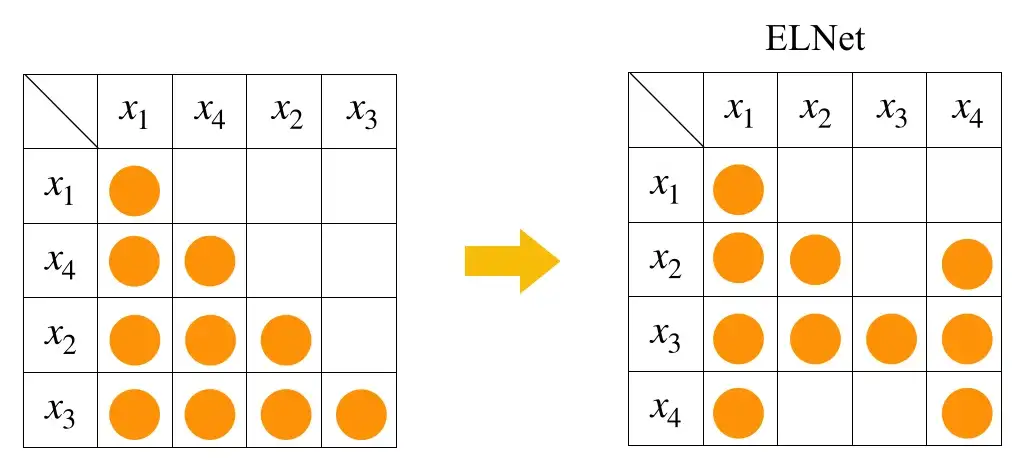
<center>Fig.1 (1->4->2->3) permutation masked attention</center>

以下為autoregressive的預測token公式, $h(x_{x<t})$在傳統autoregressive的運作模式下不會產生問題,因為model要預測token3就是要看token1, token2, 但permutation下會面臨以下狀況  

假設有兩個序列, ($x_1, x_2, x_4, x_3$), ($x_1, x_2, x_3, x_4$), 當model要同時predict兩個seq的第三個token的位置時, 兩者都是拿$x_1, x_2$去預測, model會不知道要預測$x_3$還是$x_4$
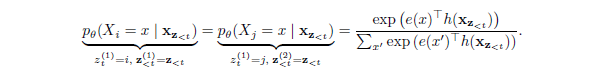  
<center>eq.1</center>

基於上述問題必須對$h(x_{x<t})$修正,改成$g_\theta(x_{x<t},z_t)$,其中$z_t$為欲預測的位置資訊

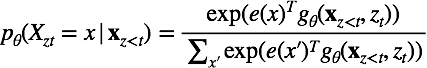  
<center>eq.2</center>

在實作$g_\theta(x_{x<t},z_t)$上, 採用two-stream self-attention的方法去實現
### Two-Stream Self-Attention  
formulation of $g_\theta(x_{x<t},z_t)$  
1. predicting the token $x_{zt}$ should only use the position $z_t$ and not the content $x_{zt}$
2. predicting other tokens $x_{zj}$$(j>t)$ should encode the content $x_{zt}$  
  
  
針對上述的兩種情況, XLNet分別採用content stream, query stream來實現  
  
  
`content stream: `  
採用標準的attention, 公式如下
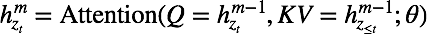  
<center>eq.3</center>  
  
  
下圖(fig2.)content stream attention圖, 與一般attention沒有不同, 以透過attention利用上下文資訊來獲得更好的token repr
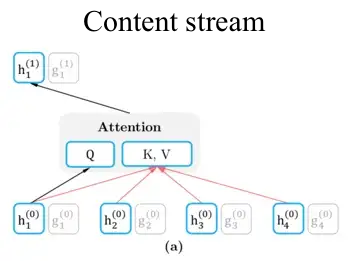
下圖(fig.3)為attention過程可視化圖, 其中mask的方式是採取permutation的方法
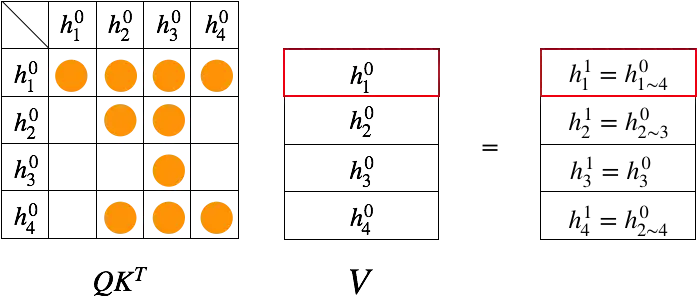
<center>Fig.3 attention result</center>

`query stream: `

下圖(fig.4)為Query stream attention可視化圖, 與content stream不同的點在於, Query不是使用h而是g, 因為當model做預測token時不能參考到自己token本身的資訊, 因此設置g去attent其他位置,公式如eq.4 
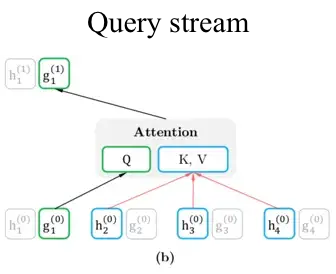
<center>fig4. Query stream attention示意圖</center>  

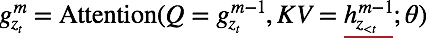  

<center>eq.4</center>

下圖(fig.5)為query stream矩陣圖, $QK^T$ 對角線的橘色點皆為空, 以此避免在predict token的時候參考到自己本身


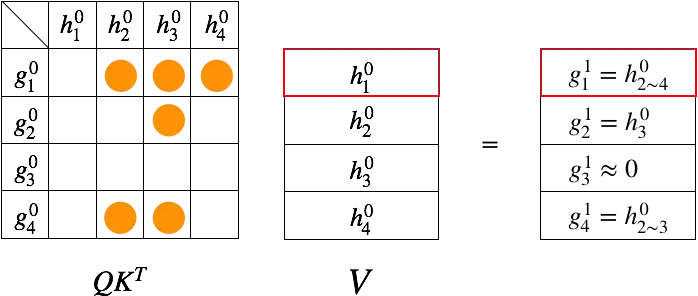  
   
   
<center>fig.5 query stream 矩陣圖</center>

下圖(fig.6)為two stream self-attention的流程圖, 針對初始化$h = e(x_i)$,token embedding + position embedding, $g = w$(可學習參數), 要設置可學習參數是因為目標任務為預測任務, 預測出目標token vector  

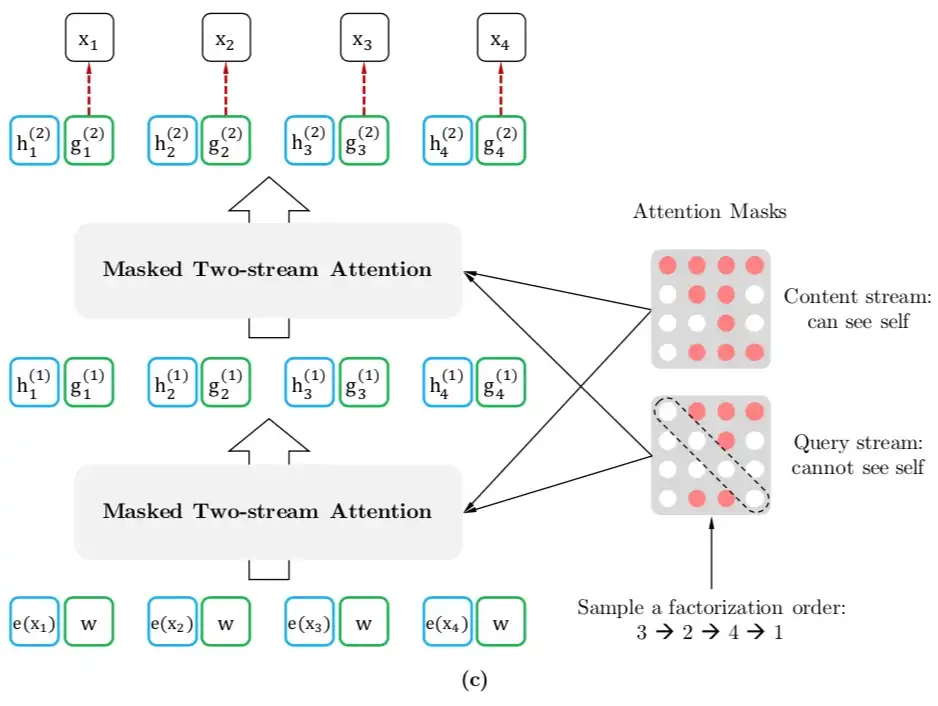
<center>fig.6 two-stream self-attention流程圖</center>

### reference  
1. https://medium.com/ai-academy-taiwan/2019-nlp%E6%9C%80%E5%BC%B7%E6%A8%A1%E5%9E%8B-xlnet-ac728b400de3
2. https://zhuanlan.zhihu.com/p/70257427
3. https://blog.csdn.net/u012526436/article/details/93196139
4. https://www.youtube.com/watch?v=FlGuTeyxjnk&t=1849s&ab_channel=VivianNTUMiuLab